# Pull Request Analysis

## Visualization Limitations for Reporting on Several Repos
The visualizations in this notebook are, like most, able to coherently display information for between 1 and 8 different repositories simultaneously. 

## Alternatives for Reporting on Repo Groups, Comprising Many Repos
The included queries could be rewritten to show an entire repository group's characteristics of that is your primary aim. Specifically, any query could replace this line: 
```
                            WHERE repo.repo_id = {repo_id}
```

with this line to accomplish the goal of comparing different groups of repositories: 
```
                            WHERE repogroups.repo_group_id = {repo_id}
```

Simply replace the set of id's in the **Pull Request Filter** section with a list of repo_group_id numbers as well, to accomplish this view. 

------------

# Connect to Your Augur Database

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})


## Pull Request Filter

In [2]:
## List of repository IDs for the report
repo_set = {25440, 25448}

# Identifying the Longest Running Pull Requests

## Getting the Data

In [3]:
pr_all = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                    SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        pr_src_author_association,
                        repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_merged_at,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
                        date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        pr_src_meta_label,
                        pr_head_or_base,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
                        first_response_time,
                        last_response_time,
                        average_time_between_responses,
                        assigned_count,
                        review_requested_count,
                        labeled_count,
                        subscribed_count,
                        mentioned_count,
                        referenced_count,
                        closed_count,
                        head_ref_force_pushed_count,
                        merged_count,
                        milestoned_count,
                        unlabeled_count,
                        head_ref_deleted_count,
                        comment_count,
                        lines_added, 
                        lines_removed,
                        commit_count, 
                        file_count
                    FROM
                        repo,
                        repo_groups,
                        pull_requests LEFT OUTER JOIN ( 
                            SELECT pull_requests.pull_request_id,
                            count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                            count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                            count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                            count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                            count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                            count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                            count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                            count(*) FILTER (WHERE action = 'closed') AS closed_count,
                            count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                            count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                            count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                            count(*) FILTER (WHERE action = 'merged') AS merged_count,
                            MIN(message.msg_timestamp) AS first_response_time,
                            COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                            MAX(message.msg_timestamp) AS last_response_time,
                            (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses
                            FROM pull_request_events, pull_requests, repo, pull_request_message_ref, message
                            WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                            AND pull_requests.pull_request_id = pull_request_events.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                            AND pull_request_message_ref.msg_id = message.msg_id
                            GROUP BY pull_requests.pull_request_id
                        ) response_times
                        ON pull_requests.pull_request_id = response_times.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT pull_request_commits.pull_request_id, count(DISTINCT pr_cmt_sha) AS commit_count                                FROM pull_request_commits, pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_cmt_sha <> pull_requests.pr_merge_commit_sha
                            AND pr_cmt_sha <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                        ) all_commit_counts
                        ON pull_requests.pull_request_id = all_commit_counts.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT MAX(pr_repo_meta_id), pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                            FROM pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_head_or_base = 'base'
                            GROUP BY pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                        ) base_labels
                        ON base_labels.pull_request_id = all_commit_counts.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT sum(cmt_added) AS lines_added, sum(cmt_removed) AS lines_removed, pull_request_commits.pull_request_id, count(DISTINCT cmt_filename) AS file_count
                            FROM pull_request_commits, commits, pull_requests, pull_request_meta
                            WHERE cmt_commit_hash = pr_cmt_sha
                            AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND commits.repo_id = pull_requests.repo_id
                            AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                            AND commits.cmt_commit_hash <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                        ) master_merged_counts 
                        ON base_labels.pull_request_id = master_merged_counts.pull_request_id                    
                    WHERE 
                        repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id} 
                    ORDER BY
                       merged_count DESC
        """)
    pr_a = pd.read_sql(pr_query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_a]) 
    else: 
        # first repo
        pr_all = pr_a
display(pr_all.head())
pr_all.dtypes

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,head_ref_force_pushed_count,merged_count,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count
0,25440,298468765,augur,MEMBER,chaoss,closed,2019-07-17 18:09:48,2019-07-17 13:25:39,2019-07-17 18:09:49,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,143.0,68.0,3.0,7.0
1,25440,333912444,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 09:37:41,2019-10-29 22:30:46,2019-10-30 09:37:41,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,28.0,53.0,3.0,4.0
2,25440,334471809,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 19:32:05,2019-10-30 19:31:57,2019-10-30 19:32:05,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,944.0,107.0,34.0,27.0
3,25440,334473172,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 20:05:27,2019-10-30 19:34:48,2019-10-30 20:05:27,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
4,25440,334642615,augur,CONTRIBUTOR,chaoss,closed,2019-10-31 11:17:26,2019-10-31 03:28:21,2019-10-31 11:17:26,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,9.0,1.0,1.0


repo_id                                     int64
pr_src_id                                   int64
repo_name                                  object
pr_src_author_association                  object
repo_group                                 object
pr_src_state                               object
pr_merged_at                       datetime64[ns]
pr_created_at                      datetime64[ns]
pr_closed_at                       datetime64[ns]
created_year                              float64
created_month                             float64
closed_year                               float64
closed_month                              float64
pr_src_meta_label                          object
pr_head_or_base                            object
hours_to_close                            float64
days_to_close                             float64
hours_to_first_response                   float64
days_to_first_response                    float64
hours_to_last_response                    float64


# Begin data pre-processing and adding columns

### Data type changing

In [4]:
# change count columns from float datatype to integer
pr_all[['assigned_count',
          'review_requested_count',
          'labeled_count',
          'subscribed_count',
          'mentioned_count',
          'referenced_count',
          'closed_count',
          'head_ref_force_pushed_count',
          'merged_count',
          'milestoned_count',
          'unlabeled_count',
          'head_ref_deleted_count',
          'comment_count',
        'commit_count',
        'file_count',
        'lines_added',
        'lines_removed'
       ]] = pr_all[['assigned_count',
                                      'review_requested_count',
                                      'labeled_count',
                                      'subscribed_count',
                                      'mentioned_count',
                                      'referenced_count',
                                      'closed_count',
                                        'head_ref_force_pushed_count',
                                    'merged_count',
                                      'milestoned_count',          
                                      'unlabeled_count',
                                      'head_ref_deleted_count',
                                      'comment_count',
                                        'commit_count',
                                        'file_count',
                                        'lines_added',
                                        'lines_removed'
                   ]].astype(float)
# Change years to int so that doesn't display as 2019.0 for example
pr_all[[
            'created_year',
           'closed_year']] = pr_all[['created_year',
                                       'closed_year']].fillna(-1).astype(int).astype(str)
pr_all.dtypes

repo_id                                     int64
pr_src_id                                   int64
repo_name                                  object
pr_src_author_association                  object
repo_group                                 object
pr_src_state                               object
pr_merged_at                       datetime64[ns]
pr_created_at                      datetime64[ns]
pr_closed_at                       datetime64[ns]
created_year                               object
created_month                             float64
closed_year                                object
closed_month                              float64
pr_src_meta_label                          object
pr_head_or_base                            object
hours_to_close                            float64
days_to_close                             float64
hours_to_first_response                   float64
days_to_first_response                    float64
hours_to_last_response                    float64


In [5]:
print(pr_all['repo_name'].unique())

['augur' 'grimoirelab']


### Add `average_days_between_responses` and `average_hours_between_responses` columns

In [6]:
# Get days for average_time_between_responses time delta

pr_all['average_days_between_responses'] = pr_all['average_time_between_responses'].map(lambda x: x.days).astype(float)
pr_all['average_hours_between_responses'] = pr_all['average_time_between_responses'].map(lambda x: x.days * 24).astype(float)

pr_all.head()

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses
0,25440,298468765,augur,MEMBER,chaoss,closed,2019-07-17 18:09:48,2019-07-17 13:25:39,2019-07-17 18:09:49,2019,...,NaN,NaN,NaN,NaN,143.0,68.0,3.0,7.0,NaN,NaN
1,25440,333912444,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 09:37:41,2019-10-29 22:30:46,2019-10-30 09:37:41,2019,...,NaN,NaN,NaN,NaN,28.0,53.0,3.0,4.0,NaN,NaN
2,25440,334471809,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 19:32:05,2019-10-30 19:31:57,2019-10-30 19:32:05,2019,...,NaN,NaN,NaN,NaN,944.0,107.0,34.0,27.0,NaN,NaN
3,25440,334473172,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 20:05:27,2019-10-30 19:34:48,2019-10-30 20:05:27,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
4,25440,334642615,augur,CONTRIBUTOR,chaoss,closed,2019-10-31 11:17:26,2019-10-31 03:28:21,2019-10-31 11:17:26,2019,...,NaN,NaN,NaN,NaN,13.0,9.0,1.0,1.0,NaN,NaN


### Date filtering entire dataframe

In [7]:
start_date = pd.to_datetime('2017-07-01 01:00:00')
# end_date = pd.to_datetime('2020-02-01 09:00:00')
end_date = pd.to_datetime('2019-12-31 23:59:59')
pr_all = pr_all[(pr_all['pr_created_at'] > start_date) & (pr_all['pr_closed_at'] < end_date)]

pr_all['created_year'] = pr_all['created_year'].map(int)
pr_all['created_month'] = pr_all['created_month'].map(int)
pr_all['created_month'] = pr_all['created_month'].map(lambda x: '{0:0>2}'.format(x))
pr_all['created_yearmonth'] = pd.to_datetime(pr_all['created_year'].map(str) + '-' + pr_all['created_month'].map(str) + '-01')
pr_all.head(1)

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses,created_yearmonth
0,25440,298468765,augur,MEMBER,chaoss,closed,2019-07-17 18:09:48,2019-07-17 13:25:39,2019-07-17 18:09:49,2019,...,NaN,NaN,NaN,143.0,68.0,3.0,7.0,NaN,NaN,2019-07-01


### add `days_to_close` column for pull requests that are still open (closed pull requests already have this column filled from the query)

Note: there will be no pull requests that are still open in the dataframe if you filtered by an end date in the above cell

In [8]:
import datetime
# getting the number of days of (today - created at) for the PRs that are still open
# and putting this in the days_to_close column

# get timedeltas of creation time to todays date/time
days_to_close_open_pr = datetime.datetime.now() - pr_all.loc[pr_all['pr_src_state'] == 'open']['pr_created_at']

# get num days from above timedelta
days_to_close_open_pr = days_to_close_open_pr.apply(lambda x: x.days).astype(int)

# for only OPEN pr's, set the days_to_close column equal to above dataframe
pr_all.loc[pr_all['pr_src_state'] == 'open'] = pr_all.loc[pr_all['pr_src_state'] == 'open'].assign(days_to_close=days_to_close_open_pr)

pr_all.loc[pr_all['pr_src_state'] == 'open'].head()

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses,created_yearmonth


### Add `closed_yearmonth` column for only CLOSED pull requests

In [9]:
# initiate column by setting all null datetimes
pr_all['closed_yearmonth'] = pd.to_datetime(np.nan)

# Fill column with prettified string of year/month closed that looks like: 2019-07-01
pr_all.loc[pr_all['pr_src_state'] == 'closed'] = pr_all.loc[pr_all['pr_src_state'] == 'closed'].assign(
    closed_yearmonth = pd.to_datetime(pr_all.loc[pr_all['pr_src_state'] == 'closed']['closed_year'].astype(int
        ).map(str) + '-' + pr_all.loc[pr_all['pr_src_state'] == 'closed']['closed_month'].astype(int).map(str) + '-01'))

pr_all.loc[pr_all['pr_src_state'] == 'closed']

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses,created_yearmonth,closed_yearmonth
0,25440,298468765,augur,MEMBER,chaoss,closed,2019-07-17 18:09:48,2019-07-17 13:25:39,2019-07-17 18:09:49,2019,...,NaN,NaN,143.0,68.0,3.0,7.0,NaN,NaN,2019-07-01,2019-07-01
1,25440,333912444,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 09:37:41,2019-10-29 22:30:46,2019-10-30 09:37:41,2019,...,NaN,NaN,28.0,53.0,3.0,4.0,NaN,NaN,2019-10-01,2019-10-01
2,25440,334471809,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 19:32:05,2019-10-30 19:31:57,2019-10-30 19:32:05,2019,...,NaN,NaN,944.0,107.0,34.0,27.0,NaN,NaN,2019-10-01,2019-10-01
3,25440,334473172,augur,CONTRIBUTOR,chaoss,closed,2019-10-30 20:05:27,2019-10-30 19:34:48,2019-10-30 20:05:27,2019,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2019-10-01,2019-10-01
4,25440,334642615,augur,CONTRIBUTOR,chaoss,closed,2019-10-31 11:17:26,2019-10-31 03:28:21,2019-10-31 11:17:26,2019,...,NaN,NaN,13.0,9.0,1.0,1.0,NaN,NaN,2019-10-01,2019-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,25448,210404861,grimoirelab,MEMBER,chaoss,closed,NaT,2018-08-23 10:41:36,2018-08-24 11:03:38,2018,...,0.0,1.0,NaN,NaN,1.0,NaN,0.0,0.0,2018-08-01,2018-08-01
160,25448,282173674,grimoirelab,MEMBER,chaoss,closed,NaT,2019-05-24 22:16:43,2019-06-03 17:05:07,2019,...,0.0,1.0,NaN,NaN,1.0,NaN,0.0,0.0,2019-05-01,2019-06-01
161,25448,240770254,grimoirelab,NONE,chaoss,closed,NaT,2018-12-24 12:44:33,2019-01-08 19:07:59,2018,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,2018-12-01,2019-01-01
163,25448,146062478,grimoirelab,MEMBER,chaoss,closed,NaT,2017-10-11 21:08:50,2017-10-14 10:27:24,2017,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,2017-10-01,2017-10-01


### Add `merged_flag` column which is just prettified strings based off of if the `pr_merged_at` column is null or not

In [10]:
""" Merged flag """
if 'pr_merged_at' in pr_all.columns.values:
    pr_all['pr_merged_at'] = pr_all['pr_merged_at'].fillna(0)
    pr_all['merged_flag'] = 'Not Merged / Rejected'
    pr_all['merged_flag'].loc[pr_all['pr_merged_at'] != 0] = 'Merged / Accepted'
    pr_all['merged_flag'].loc[pr_all['pr_src_state'] == 'open'] = 'Still Open'
    del pr_all['pr_merged_at']
pr_all['merged_flag']

0          Merged / Accepted
1          Merged / Accepted
2          Merged / Accepted
3          Merged / Accepted
4          Merged / Accepted
               ...          
159    Not Merged / Rejected
160    Not Merged / Rejected
161    Not Merged / Rejected
163    Not Merged / Rejected
165    Not Merged / Rejected
Name: merged_flag, Length: 420, dtype: object

# Split into different dataframes
### All, open, closed, and slowest 20% of these 3 categories (6 dataframes total)

In [11]:
# Isolate the different state PRs for now
pr_open = pr_all.loc[pr_all['pr_src_state'] == 'open']
pr_closed = pr_all.loc[pr_all['pr_src_state'] == 'closed']
pr_merged = pr_all.loc[pr_all['merged_flag'] == 'Merged / Accepted']
pr_not_merged = pr_all.loc[pr_all['merged_flag'] == 'Not Merged / Rejected']
pr_closed['merged_flag']

0          Merged / Accepted
1          Merged / Accepted
2          Merged / Accepted
3          Merged / Accepted
4          Merged / Accepted
               ...          
159    Not Merged / Rejected
160    Not Merged / Rejected
161    Not Merged / Rejected
163    Not Merged / Rejected
165    Not Merged / Rejected
Name: merged_flag, Length: 420, dtype: object

### Create dataframes that contain the slowest 20% pull requests of each group

In [12]:
# Filtering the 80th percentile slowest PRs

def filter_20_per_slowest(input_df):
    pr_slow20_filtered = pd.DataFrame()
    pr_slow20_x = pd.DataFrame()
    for value in repo_set: 
        if not pr_slow20_filtered.empty: 
            pr_slow20x = input_df.query('repo_id==@value')
            pr_slow20x['percentile_rank_local'] = pr_slow20x.days_to_close.rank(pct=True)
            pr_slow20x = pr_slow20x.query('percentile_rank_local >= .8', )
            pr_slow20_filtered = pd.concat([pr_slow20x, pr_slow20_filtered]) 
            reponame = str(value)
            filename = ''.join(['output/pr_slowest20pct', reponame, '.csv'])
            pr_slow20x.to_csv(filename)
        else: 
            # first time
            pr_slow20_filtered = input_df.copy()
            pr_slow20_filtered['percentile_rank_local'] = pr_slow20_filtered.days_to_close.rank(pct=True)
            pr_slow20_filtered = pr_slow20_filtered.query('percentile_rank_local >= .8', )
#     print(pr_slow20_filtered.describe())
    return pr_slow20_filtered

pr_slow20_open = filter_20_per_slowest(pr_open)
pr_slow20_closed = filter_20_per_slowest(pr_closed)
pr_slow20_merged = filter_20_per_slowest(pr_merged)
pr_slow20_not_merged = filter_20_per_slowest(pr_not_merged)
pr_slow20_all = filter_20_per_slowest(pr_all)
pr_slow20_merged#.head()

FileNotFoundError: [Errno 2] No such file or directory: 'output/pr_slowest20pct25448.csv'

# Start Visualization Methods

In [13]:
from bokeh.palettes import Colorblind, mpl, magma, Accent, GnBu3, OrRd3, Category20, inferno, Plasma256, Turbo256
import bokeh
from bokeh.layouts import gridplot
from bokeh.models.annotations import Title
from bokeh.io import export_png
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Legend, LabelSet, Range1d, LinearAxis
from bokeh.plotting import figure
from bokeh.sampledata.sprint import sprint
from bokeh.models.glyphs import Rect
from bokeh.transform import dodge

try:
    colors = Colorblind[len(repo_set)]
except:
    colors = Colorblind[3]
#mpl['Plasma'][len(repo_set)]
#['A6CEE3','B2DF8A','33A02C','FB9A99']

def remove_outliers(input_df, field, num_outliers_repo_map):
    df_no_outliers = input_df.copy()
    for repo_name, num_outliers in num_outliers_repo_map.items():
        indices_to_drop = input_df.loc[input_df['repo_name'] == repo_name].nlargest(num_outliers, field).index
        df_no_outliers = df_no_outliers.drop(index=indices_to_drop)
    return df_no_outliers


In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime as dt

def visualize_mean_days_to_close(input_df, x_axis='closed_yearmonth', description='Closed', save_file=False, num_remove_outliers=0, drop_outliers_repo=None):

    # Set the df you want to build the viz's for
    driver_df = input_df.copy()
    
    driver_df = driver_df[['repo_id', 'repo_name', 'pr_src_id', 'created_yearmonth', 'closed_yearmonth', 'days_to_close']]

    if save_file:
        driver_df.to_csv('output/c.pr_slow20small {}.csv'.format(description))
    
    driver_df_mean = driver_df.groupby(['repo_id', x_axis, 'repo_name'],as_index=False).mean()
        
    # Total PRS Closed
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(16, 8)
    plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_mean, sort=True, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Days to Close of {} Pull Requests, July 2017-January 2020".format(description))  
    if save_file:
        fig.savefig('images/slow_20_mean {}.png'.format(description))
    
    # Copying array and deleting the outlier in the copy to re-visualize
    def drop_n_largest(input_df, n, repo_name):
        input_df_copy = input_df.copy()
        indices_to_drop = input_df.loc[input_df['repo_name'] == 'amazon-freertos'].nlargest(n,'days_to_close').index
        print("Indices to drop: {}".format(indices_to_drop))
        input_df_copy = input_df_copy.drop(index=indices_to_drop)
        input_df_copy.loc[input_df['repo_name'] == repo_name]
        return input_df_copy

    if num_remove_outliers > 0 and drop_outliers_repo:
        driver_df_mean_no_outliers = drop_n_largest(driver_df_mean, num_remove_outliers, drop_outliers_repo)
    
        # Total PRS Closed without outlier
        fig, ax = plt.subplots()
        # the size of A4 paper
        fig.set_size_inches(16, 8)
        plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_mean_no_outliers, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Days to Close among {} Pull Requests Without Outlier, July 2017-January 2020".format(description))
        plotterlabels = ax.set_xticklabels(driver_df_mean_no_outliers[x_axis], rotation=90, fontsize=8)
        if save_file:
            fig.savefig('images/slow_20_mean_no_outlier {}.png'.format(description))
    

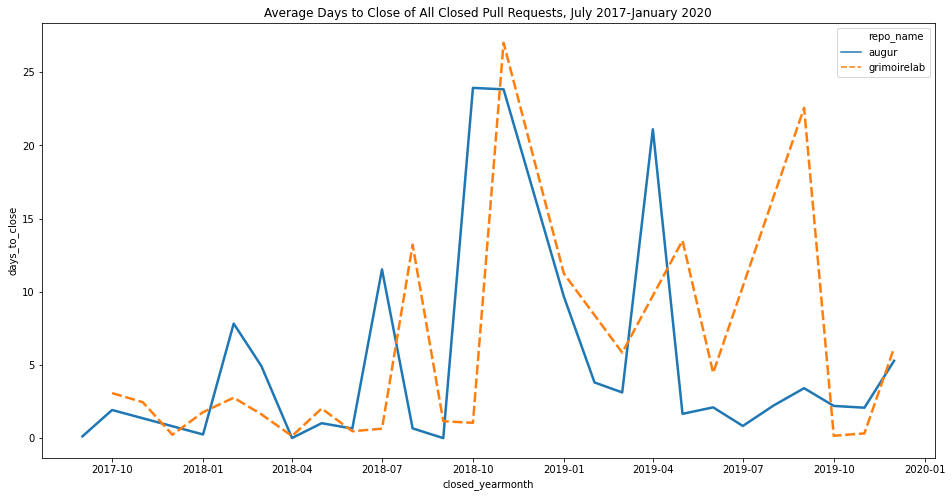

In [15]:
visualize_mean_days_to_close(pr_closed, description='All Closed', save_file=False)

In [16]:
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.transform import factor_cmap

def vertical_grouped_bar(input_df, group_by = 'merged_flag', x_axis='closed_year', y_axis='num_commits', y_max=None, repo_name=None, description="", title ="", save_file=False):
    output_notebook() # let bokeh display plot in jupyter cell output
    
    driver_df = input_df.copy() # deep copy input data so we do not change the external dataframe 
    
    # Filter df by passed *repo_name* param
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
        
    # Change closed year to int so that doesn't display as 2019.0 for example
    driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)
    
    # contains the closed years
    x_groups = sorted(list(driver_df[x_axis].unique()))
    
    # inner groups on x_axis they are merged and not_merged
    groups = list(driver_df[group_by].unique())
    
    # setup color pallete
    try:
        colors = mpl['Plasma'][len(groups)]
    except:
        colors = [mpl['Plasma'][3][0]] + [mpl['Plasma'][3][1]]
        
    merged_avg_values = list(driver_df.loc[driver_df[group_by] == 'Merged / Accepted'].groupby([x_axis],as_index=False).mean().round(1)['commit_count'])
    not_merged_avg_values = list(driver_df.loc[driver_df[group_by] == 'Not Merged / Rejected'].groupby([x_axis],as_index=False).mean().round(1)['commit_count'])
        
    # Setup data in format for grouped bar chart
    data = {
            'years' : x_groups,
            'Merged / Accepted'       : merged_avg_values,
            'Not Merged / Rejected'   : not_merged_avg_values,
        }
    
    x = [ (year, pr_state) for year in x_groups for pr_state in groups ]
    counts = sum(zip(data['Merged / Accepted'], data['Not Merged / Rejected']), ())
    
    source = ColumnDataSource(data=dict(x=x, counts=counts))

    title_beginning = '{}: '.format(repo_name) if repo_name else ''
    if y_max:
        p = figure(x_range=FactorRange(*x), plot_height=450, plot_width=700, title=title.format(title_beginning, description), y_range=(0,y_max))
    else:
        p = figure(x_range=FactorRange(*x), plot_height=450, plot_width=700, title=title.format(title_beginning, description))

    # Vertical bar glyph
    p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white",
           fill_color=factor_cmap('x', palette=colors, factors=groups, start=1, end=2))
    
    # Data label 
    labels = LabelSet(x='x', y='counts', text='counts',# y_offset=-8, x_offset=34,
              text_font_size="12pt", text_color="black",
              source=source, text_align='center')
    p.add_layout(labels)

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None
    
    p.yaxis.axis_label = 'Average Commits / Pull Request'
    p.xaxis.axis_label = 'Year Closed'
    
    p.title.align = "center"
    p.title.text_font_size = "16px"
    
    p.xaxis.axis_label_text_font_size = "15px"
    p.xaxis.major_label_text_font_size = "12px"
    
    p.yaxis.axis_label_text_font_size = "15px"
    p.yaxis.major_label_text_font_size = "15px"
    
    show(p)
    
    if save_file:
        export_png(p, filename="./images/v_grouped_bar/v_grouped_bar__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_name))
        

In [17]:
vertical_grouped_bar(pr_all, description='All', title="{}Average Commit Counts Per Year for {} Pull Requests", save_file=False, y_max=8.8)


Loading BokehJS ...

In [18]:
def vertical_grouped_bar_line_counts(input_df,  x_axis='closed_year', y_max1=600000, y_max2=1000, repo_name=None, description="", title ="", save_file=False):
    output_notebook() # let bokeh display plot in jupyter cell output
    
    driver_df = input_df.copy() # deep copy input data so we do not change the external dataframe 
    
    # Filter df by passed *repo_name* param
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
        
    # Change closed year to int so that doesn't display as 2019.0 for example
    driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)
    
    # contains the closed years
    x_groups = sorted(list(driver_df[x_axis].unique()))
    
    groups = ['Lines Added', 'Lines Removed', 'Files Changed']
    
    # setup color pallete
    colors = mpl['Plasma'][3]
    
    display(pr_all[pr_all['lines_added'].notna()])#.groupby([x_axis],as_index=False).mean())
        
    files_avg_values = list(driver_df.groupby([x_axis],as_index=False).mean().round(1)['file_count'])
    added_avg_values = list(driver_df.groupby([x_axis],as_index=False).mean().round(1)['lines_added'])
    removed_avg_values = list(driver_df.groupby([x_axis],as_index=False).mean().round(1)['lines_removed'])
    display(driver_df.groupby([x_axis],as_index=False).mean())
    print(files_avg_values)
    print(added_avg_values)
    print(removed_avg_values)
    
        
    # Setup data in format for grouped bar chart
    data = {
            'years' : x_groups,
            'Lines Added'   : added_avg_values,
            'Lines Removed' : removed_avg_values,
            'Files Changed' : files_avg_values
        }

    x = [ (year, pr_state) for year in x_groups for pr_state in groups ]
    line_counts = sum(zip(data['Lines Added'], data['Lines Removed'], [0]*len(x_groups)), ())
    file_counts = sum(zip([0]*len(x_groups),[0]*len(x_groups),data['Files Changed']), ())
    print(line_counts)
    print(file_counts)
    
    source = ColumnDataSource(data=dict(x=x, line_counts=line_counts, file_counts=file_counts))

    if y_max1:
        p = figure(x_range=FactorRange(*x), plot_height=450, plot_width=700, title=title.format(description), y_range=(0,y_max1))
    else:
        p = figure(x_range=FactorRange(*x), plot_height=450, plot_width=700, title=title.format(description))
                
    # Setting the second y axis range name and range
    p.extra_y_ranges = {"file_counts": Range1d(start=0, end=y_max2)}
    
    # Adding the second axis to the plot.  
    p.add_layout(LinearAxis(y_range_name="file_counts"), 'right')
    
    # Data label for line counts
    labels = LabelSet(x='x', y='line_counts', text='line_counts',y_offset=8,# x_offset=34,
              text_font_size="10pt", text_color="black",
              source=source, text_align='center')
    p.add_layout(labels)

    # Vertical bar glyph for line counts
    p.vbar(x='x', top='line_counts', width=0.9, source=source, line_color="white",
           fill_color=factor_cmap('x', palette=colors, factors=groups, start=1, end=2))
    
    # Data label for file counts
    labels = LabelSet(x='x', y='file_counts', text='file_counts', y_offset=0, #x_offset=34,
              text_font_size="10pt", text_color="black",
              source=source, text_align='center', y_range_name="file_counts")
    p.add_layout(labels)
    
    # Vertical bar glyph for file counts
    p.vbar(x='x', top='file_counts', width=0.9, source=source, line_color="white",
           fill_color=factor_cmap('x', palette=colors, factors=groups, start=1, end=2), y_range_name="file_counts")

    p.left[0].formatter.use_scientific = False
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None
    
    p.yaxis.axis_label = 'Average Commits / Pull Request'
    p.xaxis.axis_label = 'Year Closed'
    
    p.title.align = "center"
    p.title.text_font_size = "16px"
    
    p.xaxis.axis_label_text_font_size = "15px"
    p.xaxis.major_label_text_font_size = "12px"
    
    p.yaxis.axis_label_text_font_size = "15px"
    p.yaxis.major_label_text_font_size = "15px"
    
    show(p)
    
    if save_file:
        export_png(p, filename="./images/v_grouped_bar/v_grouped_bar__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_name))
        

In [19]:
""" THIS VIZ IS NOT READY YET , BUT UNCOMMENT LINE BELOW IF YOU WANT TO SEE"""
# vertical_grouped_bar_line_counts(pr_all, description='All', title="Average Size Metrics Per Year for {} Merged Pull Requests in Master", save_file=False, y_max1=580000, y_max2=1100)
None

In [20]:
def horizontal_stacked_bar(input_df, group_by='merged_flag', x_axis='comment_count', repo_name=None, x_max=1000, description="", y_axis='repo_name', title="Average Pull Request Comments by Merged Status", save_file=False):
    driver_df = input_df.copy()
    
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
        
    output_notebook()
    
    try:
        y_groups = sorted(list(driver_df[y_axis].unique()))
    except:
        y_groups = [repo_name]
        
    groups = driver_df[group_by].unique()
    try:
        colors = mpl['Plasma'][len(groups)]
    except:
        colors = [mpl['Plasma'][3][0]] + [mpl['Plasma'][3][1]]
        
    len_not_merged = len(driver_df.loc[driver_df['merged_flag'] == 'Not Merged / Rejected'])
    len_merged = len(driver_df.loc[driver_df['merged_flag'] == 'Merged / Accepted'])

    title_beginning = '{}: '.format(repo_name) if repo_name else ''
    p = figure(y_range=y_groups, plot_height=450, plot_width=650, x_range=(0,x_max), # y_range=y_groups,#(pr_all[y_axis].min(),pr_all[y_axis].max()) #y_axis_type="datetime",
               title='{} {}'.format(title_beginning, title.format(description)))

    for y_value in y_groups:

        y_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Merged / Accepted')]
        y_not_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Not Merged / Rejected')]

        if len(y_merged_data) > 0:
            y_merged_data[x_axis + '_mean'] = y_merged_data[x_axis].mean().round(1)
        else:
            y_merged_data[x_axis + '_mean'] = 0.00

        if len(y_not_merged_data) > 0:
            y_not_merged_data[x_axis + '_mean'] = y_not_merged_data[x_axis].mean().round(1)
        else:
            y_not_merged_data[x_axis + '_mean'] = 0

        not_merged_source = ColumnDataSource(y_not_merged_data)
        merged_source = ColumnDataSource(y_merged_data)

        # mean comment count for merged
        merged_comment_count_glyph = p.hbar(y=dodge(y_axis, -0.1, range=p.y_range), left=0, right=x_axis + '_mean', height=0.04*len(driver_df[y_axis].unique()), 
                                     source=merged_source, fill_color="black")#,legend_label="Mean Days to Close",
        # Data label 
        labels = LabelSet(x=x_axis + '_mean', y=dodge(y_axis, -0.1, range=p.y_range), text=x_axis + '_mean', y_offset=-8, x_offset=34,
                  text_font_size="12pt", text_color="black",
                  source=merged_source, text_align='center')
        p.add_layout(labels)
        # mean comment count For nonmerged
        not_merged_comment_count_glyph = p.hbar(y=dodge(y_axis, 0.1, range=p.y_range), left=0, right=x_axis + '_mean', 
                                     height=0.04*len(driver_df[y_axis].unique()), source=not_merged_source, fill_color="#e84d60")#legend_label="Mean Days to Close",
        # Data label 
        labels = LabelSet(x=x_axis + '_mean', y=dodge(y_axis, 0.1, range=p.y_range), text=x_axis + '_mean', y_offset=-8, x_offset=34,
                  text_font_size="12pt", text_color="#e84d60",
                  source=not_merged_source, text_align='center')
        p.add_layout(labels)

#         p.y_range.range_padding = 0.1
    p.ygrid.grid_line_color = None
    p.legend.location = "bottom_right"
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.xaxis.axis_label = 'Average Comments / Pull Request'
    p.yaxis.axis_label = 'Repository' if y_axis == 'repo_name' else 'Year Closed' if y_axis == 'closed_year' else ''

    legend = Legend(
            items=[
                ("Merged Pull Request Mean Comment Count", [merged_comment_count_glyph]),
                ("Rejected Pull Request Mean Comment Count", [not_merged_comment_count_glyph])
            ],

            location='center', 
            orientation='vertical',
            border_line_color="black"
        )
    p.add_layout(legend, "below")
            
    show(p, plot_width=1200, plot_height=1200)
    
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(p, filename="./images/h_stacked_bar_mean_comments_merged_status/mean_comments_merged_status__facet_{}__{}_PRs__yaxis_{}__repo_{}.png".format(facet, description, y_axis, repo_extension))


In [21]:
horizontal_stacked_bar(pr_closed, description="All Closed", group_by='merged_flag', save_file=False, x_max=5.8, x_axis='comment_count', y_axis='closed_year', title="Mean Comments for {} Pull Requests")


Loading BokehJS ...

In [22]:
def merged_ratio_vertical_grouped_bar(data_dict, repo_name=None, x_axis='repo_name', save_file=False, y_max=5000, description="All", title="{}"):
        
    output_notebook()
        
    colors = mpl['Plasma'][6]
        
    if repo_name == 'mbed-os':
        colors = colors[::-1]
    
    for data_desc, input_df in data_dict.items():
        x_groups = sorted(list(input_df[x_axis].astype(str).unique()))
        break
    
    title_beginning = '{}: ' if repo_name else ''
    p = figure(x_range=x_groups, y_range=(0, y_max), plot_height=350, plot_width=750,  
               title='{} {}'.format(title_beginning, title.format(description)))
    
    dodge_amount = 0.12
    color_index = 0
    x_offset = 50
    for data_desc, input_df in data_dict.items():
        driver_df = input_df.copy()
        
        driver_df[x_axis] = driver_df[x_axis].astype(str)
        
        groups = sorted(list(driver_df['merged_flag'].unique()))
    
        if repo_name:
            driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
            
        len_merged = []
        zeros = []
        len_not_merged = []
        totals = []
        for x_group in x_groups:
            print(x_group)
            
            len_merged_entry = len(driver_df.loc[(driver_df['merged_flag'] == 'Merged / Accepted') & (driver_df[x_axis] == x_group)])
            totals += [len(driver_df.loc[(driver_df['merged_flag'] == 'Not Merged / Rejected') & (driver_df[x_axis] == x_group)]) + len_merged_entry]
            len_not_merged += [len(driver_df.loc[(driver_df['merged_flag'] == 'Not Merged / Rejected') & (driver_df[x_axis] == x_group)])]
            len_merged += [len_merged_entry]
            zeros.append(0)
            print(len_merged, len_not_merged)
        
        data = {'X': x_groups}
        for group in groups:
            data[group] = []
            for x_group in x_groups:
                data[group] += [len(driver_df.loc[(driver_df['merged_flag'] == group) & (driver_df[x_axis] == x_group)])]

        data['len_merged'] = len_merged
        data['len_not_merged'] = len_not_merged
        data['totals'] = totals
        data['zeros'] = zeros
        source = ColumnDataSource(data)

        stacked_bar = p.vbar_stack(groups, x=dodge('X', dodge_amount, range=p.x_range), width=0.2, source=source, color=colors[1:3], legend_label=[f"{data_desc} " + "%s" % x for x in groups])
        # Data label for merged
        p.add_layout(
            LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='zeros', text='len_merged', y_offset=2, x_offset=x_offset,
                  text_font_size="12pt", text_color=colors[1:3][0],
                  source=source, text_align='center')
        )
        # Data label for not merged
        p.add_layout(
            LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='totals', text='len_not_merged', y_offset=0, x_offset=x_offset,
                  text_font_size="12pt", text_color=colors[1:3][1],
                  source=source, text_align='center')
        )
        # Data label for total
        p.add_layout(
            LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='totals', text='totals', y_offset=0, x_offset=0,
                  text_font_size="12pt", text_color='black',
                  source=source, text_align='center')
        )
        dodge_amount *= -1
        colors = colors[::-1]
        x_offset *= -1

    p.xgrid.grid_line_color = None
    p.legend.location = "top_left"
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.yaxis.axis_label = 'Count of Pull Requests'
    p.xaxis.axis_label = 'Repository' if x_axis == 'repo_name' else 'Year Closed' if x_axis == 'closed_year' else ''
    
    p.title.align = "center"
    p.title.text_font_size = "16px"

    p.xaxis.axis_label_text_font_size = "16px"
    p.xaxis.major_label_text_font_size = "16px"

    p.yaxis.axis_label_text_font_size = "16px"
    p.yaxis.major_label_text_font_size = "16px"

    p.outline_line_color = None
    show(p, plot_width=1200, plot_height=1200)
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(p, filename="./images/v_stacked_bar_merged_status_count/stacked_bar_merged_status_count__facet_{}__{}_PRs__xaxis_{}__repo_{}.png".format(facet, description, x_axis, repo_extension))
        

In [23]:
# for repo_name in pr_all['repo_name'].unique():
merged_ratio_vertical_grouped_bar({'All':pr_closed,'Slowest 20%':pr_slow20_not_merged.append(pr_slow20_merged,ignore_index=True)}, description="All Closed", y_max=3800, x_axis='closed_year', save_file=False, title="Count of {} Pull Requests by Merged Status")


NameError: name 'pr_slow20_not_merged' is not defined

In [35]:
def visualize_mean_response_times(input_df, time_unit='days', repo_name=None, y_axis='closed_year', description="All", x_max=95, save_file=False, legend_position=(410, 10)):

    output_notebook() # let bokeh show plot in jupyter cell output
    
    driver_df = input_df.copy()[['repo_name', 'merged_flag', y_axis, time_unit + '_to_first_response', time_unit + '_to_last_response', 
                                 time_unit + '_to_close']] # deep copy input data so we do not alter the external dataframe
    
    # filter by repo_name param
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]

    title_beginning = '' if not repo_name else '{}: '.format(repo_name)
    p = figure(toolbar_location=None, y_range=sorted(driver_df[y_axis].unique()), x_range=(-2,x_max), plot_width=950, 
               plot_height=450,#75*len(driver_df[y_axis].unique()),
               title="Mean Response Times for {} Pull Requests {}".format(title_beginning, description))
    
    first_response_glyphs = []
    last_response_glyphs = []
    merged_days_to_close_glyphs = []
    not_merged_days_to_close_glyphs = []

    for y_value in driver_df[y_axis].unique():

        y_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Merged / Accepted')]
        y_not_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Not Merged / Rejected')]

        y_merged_data[time_unit + '_to_first_response_mean'] = y_merged_data[time_unit + '_to_first_response'].mean().round(1) if len(y_merged_data) > 0 else 0.00
        y_merged_data[time_unit + '_to_last_response_mean'] = y_merged_data[time_unit + '_to_last_response'].mean().round(1) if len(y_merged_data) > 0 else 0.00
        y_merged_data[time_unit + '_to_close_mean'] = y_merged_data[time_unit + '_to_close'].mean().round(1) if len(y_merged_data) > 0 else 0.00
        
        y_not_merged_data[time_unit + '_to_first_response_mean'] = y_not_merged_data[time_unit + '_to_first_response'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00
        y_not_merged_data[time_unit + '_to_last_response_mean'] = y_not_merged_data[time_unit + '_to_last_response'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00
        y_not_merged_data[time_unit + '_to_close_mean'] = y_not_merged_data[time_unit + '_to_close'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00

        not_merged_source = ColumnDataSource(y_not_merged_data)
        merged_source = ColumnDataSource(y_merged_data)

        # mean PR length for merged
        merged_days_to_close_glyph = p.hbar(y=dodge(y_axis, -0.1, range=p.y_range), left=0, right=time_unit + '_to_close_mean', height=0.04*len(driver_df[y_axis].unique()), 
                                     source=merged_source, fill_color="black")#,legend_label="Mean Days to Close",
        merged_days_to_close_glyphs.append(merged_days_to_close_glyph)
        # Data label 
        labels = LabelSet(x=time_unit + '_to_close_mean', y=dodge(y_axis, -0.1, range=p.y_range), text=time_unit + '_to_close_mean', y_offset=-8, x_offset=20, #34
                  text_font_size="12pt", text_color="black",
                  source=merged_source, text_align='center')
        p.add_layout(labels)
        # mean PR length For nonmerged
        not_merged_days_to_close_glyph = p.hbar(y=dodge(y_axis, 0.1, range=p.y_range), left=0, right=time_unit + '_to_close_mean', 
                                     height=0.04*len(driver_df[y_axis].unique()), source=not_merged_source, fill_color="#e84d60")#legend_label="Mean Days to Close",
        not_merged_days_to_close_glyphs.append(not_merged_days_to_close_glyph)
        # Data label 
        labels = LabelSet(x=time_unit + '_to_close_mean', y=dodge(y_axis, 0.1, range=p.y_range), text=time_unit + '_to_close_mean', y_offset=-8, x_offset=44,
                  text_font_size="12pt", text_color="#e84d60",
                  source=not_merged_source, text_align='center')
        p.add_layout(labels)

        # mean time to first response
        glyph = Rect(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, -0.1, range=p.y_range), width=x_max/100, height=0.08*len(driver_df[y_axis].unique()), fill_color=colors[0])
        first_response_glyph = p.add_glyph(merged_source, glyph)
        first_response_glyphs.append(first_response_glyph)
        # Data label 
        labels = LabelSet(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0, range=p.y_range),text=time_unit + '_to_first_response_mean', y_offset=-45,#-75,
                  text_font_size="12pt", text_color=colors[0],
                  source=merged_source, text_align='center')
        p.add_layout(labels)
        #for nonmerged
        glyph = Rect(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0.1, range=p.y_range), width=x_max/100, height=0.08*len(driver_df[y_axis].unique()), fill_color=colors[0])
        first_response_glyph = p.add_glyph(not_merged_source, glyph)
        first_response_glyphs.append(first_response_glyph)
        # Data label 
        labels = LabelSet(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0, range=p.y_range),text=time_unit + '_to_first_response_mean', y_offset=25,#55,
                          text_font_size="12pt", text_color=colors[0],
                  source=not_merged_source, text_align='center')
        p.add_layout(labels)

        # mean time to last response
        glyph = Rect(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, -0.1, range=p.y_range), width=x_max/100, height=0.08*len(driver_df[y_axis].unique()), fill_color=colors[1])
        last_response_glyph = p.add_glyph(merged_source, glyph)
        last_response_glyphs.append(last_response_glyph)
        # Data label 
        labels = LabelSet(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0, range=p.y_range), text=time_unit + '_to_last_response_mean', y_offset=-45,#-75,
                  text_font_size="12pt", text_color=colors[1],
                  source=merged_source, text_align='center')
        p.add_layout(labels)
        #for nonmerged
        glyph = Rect(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0.1, range=p.y_range), width=x_max/100, height=0.08*len(driver_df[y_axis].unique()), fill_color=colors[1])
        last_response_glyph = p.add_glyph(not_merged_source, glyph)
        last_response_glyphs.append(last_response_glyph)
        # Data label 
        labels = LabelSet(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0, range=p.y_range), text=time_unit + '_to_last_response_mean', y_offset=25,#55,
                  text_font_size="12pt", text_color=colors[1],
                  source=not_merged_source, text_align='center')
        p.add_layout(labels)
            
    p.title.align = "center"
    p.title.text_font_size = "16px"

    p.xaxis.axis_label = "Days to Close"
    p.xaxis.axis_label_text_font_size = "16px"
    p.xaxis.major_label_text_font_size = "16px"

    p.yaxis.axis_label = "Repository" if y_axis == 'repo_name' else 'Year Closed' if y_axis == 'closed_year' else ''
    p.yaxis.axis_label_text_font_size = "16px"
    p.yaxis.major_label_text_font_size = "16px"
    p.ygrid.grid_line_color = None
    p.y_range.range_padding = 0.15

    p.outline_line_color = None
    p.toolbar.logo = None
    p.toolbar_location = None

    def add_legend(location, orientation, side):
        legend = Legend(
            items=[
                ("Mean Days to First Response", first_response_glyphs),
                ("Mean Days to Last Response", last_response_glyphs),
                ("Merged Mean Days to Close", merged_days_to_close_glyphs),
                ("Not Merged Mean Days to Close", not_merged_days_to_close_glyphs)
            ],

            location=location, 
            orientation=orientation,
            border_line_color="black"
    #         title='Example Title'
        )
        p.add_layout(legend, side)

#     add_legend((150, 50), "horizontal", "center")
    add_legend(legend_position, "vertical", "right")
    viz_width=x_max/100, 
    viz_height=0.08*len(driver_df[y_axis].unique()
        
    show(p, plot_width=1200, plot_height=1200)
#    show(p, plot_width=viz_width, plot_height=viz_height)
 
    
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(p, filename="./images/hbar_response_times/mean_response_times__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_extension))
        

SyntaxError: invalid syntax (<ipython-input-35-d353b1b71a56>, line 134)

In [25]:
# for repo_name in pr_closed['repo_name'].unique():
visualize_mean_response_times(pr_closed, description="All Closed", y_axis='closed_year', x_max=244, save_file=False, legend_position='center')


Loading BokehJS ...

In [26]:
def visualize_mean_time_between_responses(data_dict, time_unit='Hours', x_axis='closed_yearmonth', description='', line_group='merged_flag',repo_name=None, y_max=800, y_axis='average_hours_between_responses', num_outliers_repo_map={}, save_file=False):
    
    output_notebook()
    
    p1 = figure(x_axis_type="datetime", title="Mean {} Between Comments by Month Closed for {} Pull Requests".format(time_unit, description), plot_width=950, x_range=(pr_all[x_axis].min(),pr_all[x_axis].max()),y_range=(0,y_max), plot_height=500)
    colors = Category20[10][6:]
    color_index = 0
    
    glyphs = []
    
    for data_desc, input_df in data_dict.items():
    
        driver_df = input_df.copy()

        driver_df = remove_outliers(driver_df, y_axis, num_outliers_repo_map)

        if repo_name:
            driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]

        index = 0

        driver_df_mean = driver_df.groupby(['repo_id', line_group, x_axis],as_index=False).mean()

        title_ending = ''
        if repo_name:
            title_ending += ' for Repo: {}'.format(repo_name)
        
        for group_num, line_group_value in enumerate(driver_df[line_group].unique(), color_index):
            glyphs.append(p1.line(driver_df_mean.loc[driver_df_mean[line_group] == line_group_value][x_axis], driver_df_mean.loc[driver_df_mean[line_group] == line_group_value][y_axis], color=colors[group_num]))
            color_index += 1

    for repo, num_outliers in num_outliers_repo_map.items():
        if repo_name == repo:
            p1.add_layout(Title(text="** {} outliers for {} were removed".format(num_outliers, repo), align="center"), "below")
                
    p1.grid.grid_line_alpha = 0.3
    p1.xaxis.axis_label = 'Month Closed'
    p1.xaxis.ticker.desired_num_ticks = 15
    p1.yaxis.axis_label = 'Mean {} Between Responses'.format(time_unit)
    p1.legend.location = "top_left"
    
    legend = Legend(
        items=[
            ("All Not Merged / Rejected", [glyphs[0]]),
            ("All Merged / Accepted", [glyphs[1]]),
            ("Slowest 20% Not Merged / Rejected", [glyphs[2]]),
            ("Slowest 20% Merged / Accepted", [glyphs[3]])
        ],

        location='center_right', 
        orientation='vertical',
        border_line_color="black"
    )
    p1.add_layout(legend, 'right')

    show(p1, plot_width=1200, plot_height=1200)

    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/line_mean_time_between_comments/line_mean_time_between_comments__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_extension))


In [27]:
# for repo_name in pr_all['repo_name'].unique():
visualize_mean_time_between_responses({'All':pr_closed,'Slowest 20%':pr_slow20_not_merged.append(pr_slow20_merged,ignore_index=True)}, line_group='merged_flag',description="All Closed", x_axis='closed_yearmonth', save_file=False, y_max=190, time_unit='Days', y_axis='average_days_between_responses')


NameError: name 'pr_slow20_not_merged' is not defined

In [28]:
def visualize_time_to_first_comment(input_df, repo_name=None, x_axis='pr_created_at', y_max=300, y_axis='days_to_first_response', description=None, num_outliers_repo_map={}, group_by='merged_flag', same_scales=True, columns=2, legend_position='top_right', save_file=False):
    output_notebook()#
    
    driver_df = input_df.copy()#
    
    #
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
        
    # 
    group_by_groups = sorted(driver_df[group_by].unique())

    title_beginning = '{}: '.format(repo_name.capitalize()) if repo_name else ''
    p = figure(x_range=(driver_df[x_axis].min() - datetime.timedelta(days=30), driver_df[x_axis].max() + datetime.timedelta(days=25)), 
               y_range=(0, y_max),#(driver_df[y_axis].min(), driver_df[y_axis].max()), 
               toolbar_location=None,
               title='{}Days to First Response for {} Closed Pull Requests'.format(title_beginning, description), plot_width=900, plot_height=400, x_axis_type='datetime')

    outliers = driver_df.loc[driver_df[y_axis] > y_max]
    if len(outliers) > 0:
        if repo_name:
            p.add_layout(Title(text="** Outliers cut off at {} days: {} outlier(s) for {} were removed **".format(y_max, len(outliers), repo_name), align="center"), "below")
        else:
            p.add_layout(Title(text="** Outliers cut off at {} days: {} outlier(s) were removed **".format(y_max, len(outliers)), align="center"), "below")

    for index, group_by_group in enumerate(group_by_groups):
        p.scatter(x_axis, y_axis, color=colors[index], marker="square", source=driver_df.loc[driver_df[group_by] == group_by_group], legend_label=group_by_group)

    p.xaxis.axis_label = 'Date Closed' if x_axis == 'pr_closed_at' else 'Date Created' if x_axis == 'pr_created_at' else 'Date'
    p.yaxis.axis_label = 'Days to First Response'
    p.legend.location = legend_position
    
    p.title.align = "center"
    p.title.text_font_size = "15px"

    p.xaxis.axis_label_text_font_size = "16px"
    p.xaxis.major_label_text_font_size = "16px"

    p.yaxis.axis_label_text_font_size = "16px"
    p.yaxis.major_label_text_font_size = "16px"
            
    show(p, plot_width=1200, plot_height=1200)
    
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(p, filename="./images/first_comment_times/scatter_first_comment_times__{}_PRs__xaxis_{}__repo_{}.png".format(description, x_axis, repo_extension))
        

In [29]:
# for repo_name in pr_all['repo_name'].unique():
visualize_time_to_first_comment(pr_closed, save_file=False, y_max=180, x_axis='pr_closed_at', group_by='merged_flag', y_axis='days_to_first_response', description="All", legend_position='top_right')


Loading BokehJS ...

In [30]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
    colors in RGB and hex form for use in a graphing function
    defined later on '''
    return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
      "r":[RGB[0] for RGB in gradient],
      "g":[RGB[1] for RGB in gradient],
      "b":[RGB[2] for RGB in gradient]}

def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])

def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
    ''' returns a gradient list of (n) colors between
    two hex colors. start_hex and finish_hex
    should be the full six-digit color string,
    inlcuding the number sign ("#FFFFFF") '''
    # Starting and ending colors in RGB form
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(finish_hex)
    # Initilize a list of the output colors with the starting color
    RGB_list = [s]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
          int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
          for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)

    return color_dict(RGB_list)

In [31]:
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.transform import transform

def event_types_heat_map(input_df, include_comments=False, repo_name=None, x_axis='closed_year',facet="merged_flag",columns=2, x_max=1100, same_scales=True, save_file=False, y_axis='repo_name', description="All", title="Average Pull Request Comments by Merged Status"):
    colors = linear_gradient('#f5f5dc', '#fff44f', 150)['hex']

    driver_df = input_df.copy()
    driver_df[x_axis] = driver_df[x_axis].astype(str)
    
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
    
    if facet == 'closed_year' or y_axis == 'closed_year':
        driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)
        
    optional_comments = ['comment_count'] if include_comments else []
    driver_df = driver_df[['repo_id', 'repo_name',x_axis, 'assigned_count',
          'review_requested_count',
          'labeled_count',
          'subscribed_count',
          'mentioned_count',
          'referenced_count',
          'closed_count',
          'head_ref_force_pushed_count',
          'merged_count',
          'milestoned_count',
          'unlabeled_count',
          'head_ref_deleted_count', facet ] + optional_comments]
    y_groups = ['assigned_count',
          'review_requested_count',
          'labeled_count',
          'subscribed_count',
          'mentioned_count',
          'referenced_count',
          'closed_count',
          'head_ref_force_pushed_count',
          'merged_count',
          'milestoned_count',
          'unlabeled_count',
          'head_ref_deleted_count'] + optional_comments
    output_notebook()
    optional_group_comments = ['comment'] if include_comments else []
#     y_groups = ['subscribed', 'mentioned', 'labeled', 'review_requested', 'head_ref_force_pushed', 'referenced', 'closed', 'merged', 'unlabeled', 'head_ref_deleted', 'milestoned', 'assigned'] + optional_group_comments

    x_groups = sorted(list(driver_df[x_axis].unique()))
    
    grid_array = []
    grid_row = []  
    
    for index, facet_group in enumerate(sorted(driver_df[facet].unique())):
        print(facet_group)
        
        facet_data = driver_df.loc[driver_df[facet] == facet_group]
        print(len(facet_data))
#         display(facet_data.sort_values('merged_count', ascending=False).head(50))
        driver_df_mean = facet_data.groupby(['repo_id', 'repo_name', x_axis], as_index=False).mean().round(1)
#         data = {'Y' : y_groups}
#         for group in y_groups:
#             data[group] = driver_df_mean[group].tolist()
    
        title_ending = 'Created in {}'.format(facet_group) if facet == 'created_year' else 'Closed in {}'.format(facet_group) if facet == 'closed_year' else 'for Repo: {}'.format(repo_name) if repo_name else facet_group
        p = figure(y_range=y_groups, plot_height=700, plot_width=900, x_range=x_groups, 
                   title='{} {}'.format(title.format(description), title_ending))
        
        for y_group in y_groups:
            driver_df_mean['field'] = y_group
            source = ColumnDataSource(driver_df_mean)
            mapper = LinearColorMapper(palette=colors, low=driver_df_mean[y_group].min(), high=driver_df_mean[y_group].max())
            
            p.rect(y='field', x=x_axis, width=1, height=1, source=source,
                   line_color=None, fill_color=transform(y_group, mapper))
            # Data label 
            labels = LabelSet(x=x_axis, y='field', text=y_group, y_offset=-8,
                      text_font_size="12pt", text_color='black',
                      source=source, text_align='center')
            p.add_layout(labels)

            color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                                 ticker=BasicTicker(desired_num_ticks=9),
                                 formatter=PrintfTickFormatter(format="%d"))
#         p.add_layout(color_bar, 'right')
        
        p.y_range.range_padding = 0.1
        p.ygrid.grid_line_color = None
        
        p.legend.location = "bottom_right"
        p.axis.minor_tick_line_color = None
        p.outline_line_color = None
        
        p.xaxis.axis_label = 'Year Closed'
        p.yaxis.axis_label = 'Event Type'
        
        p.title.align = "center"
        p.title.text_font_size = "12px"
        
        p.xaxis.axis_label_text_font_size = "16px"
        p.xaxis.major_label_text_font_size = "16px"
        
        p.yaxis.axis_label_text_font_size = "16px"
        p.yaxis.major_label_text_font_size = "16px"
                
        grid_row.append(p)
        if index % columns == columns - 1:
            grid_array.append(grid_row)
            grid_row = []
    grid = gridplot(grid_array)
    show(grid, plot_width=1200, plot_height=1200)
    if save_file:
        comments_included = 'comments_included' if include_comments else 'comments_not_included'
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/h_stacked_bar_mean_event_types/mean_event_types__facet_{}__{}_PRs__yaxis_{}__{}__repo_{}.png".format(facet, description, y_axis, comments_included, repo_extension))
      


In [32]:
# for repo_name in pr_all['repo_name'].unique():
event_types_heat_map(pr_closed, facet="merged_flag", save_file=False, x_axis='closed_year', description="All Closed", include_comments=True, title="Average Pull Request Event Types for {} Pull Requests")


Loading BokehJS ...

Merged / Accepted
361
Not Merged / Rejected
59


In [33]:
from bokeh.plotting import figure

red_green_gradient = linear_gradient('#0080FF', '#DC143C', 150)['hex']
    #32CD32
def heat_map(input_df, repo_name=None,x_axis='repo_id', group_by='merged_flag', y_axis='closed_yearmonth', heat_max=300, save_file=False, same_scales=True, description="All", heat_field='days_to_first_response', columns=2):
    
    output_notebook()
    
    driver_df = input_df.copy()[['repo_id', y_axis, group_by, x_axis, heat_field]]
    
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
        
    driver_df[y_axis] = driver_df[y_axis].astype(str)
    
    # add new group by + xaxis column 
    driver_df['grouped_x'] = driver_df[x_axis] + ' - ' + driver_df[group_by]

    driver_df_mean = driver_df.groupby(['grouped_x', y_axis], as_index=False).mean()

    colors = red_green_gradient
    y_groups = driver_df_mean[y_axis].unique()
    x_groups = sorted(driver_df[x_axis].unique())
    grouped_x_groups = sorted(driver_df_mean['grouped_x'].unique())
    print(grouped_x_groups)
    
    mapper = LinearColorMapper(palette=colors, low=driver_df_mean[heat_field].min(), high=heat_max)#driver_df_mean[heat_field].max())
    
    source = ColumnDataSource(driver_df_mean)

    p = figure(plot_width=1100, plot_height=300, title="Mean Duration (Days) {} Pull Requests".format(description),
               y_range=grouped_x_groups[::-1], x_range=y_groups,
               toolbar_location=None, tools="")#, x_axis_location="above")

    for x_group in x_groups:
        outliers = driver_df_mean.loc[(driver_df_mean[heat_field] > heat_max) & (driver_df_mean['grouped_x'].str.contains(x_group))]
        print(outliers)
        if len(outliers) > 0:
            p.add_layout(Title(text="** Outliers capped at {} days: {} outlier(s) for {} were capped at {} **".format(heat_max, len(outliers), x_group, heat_max), align="center"), "below")

    p.rect(x=y_axis, y='grouped_x', width=1, height=1, source=source,
           line_color=None, fill_color=transform(heat_field, mapper))

    color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                         ticker=BasicTicker(desired_num_ticks=9),
                         formatter=PrintfTickFormatter(format="%d"))

    p.add_layout(color_bar, 'right')
    
    p.title.align = "center"
    p.title.text_font_size = "14px"

    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "11pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = 1.0
    p.xaxis.axis_label = 'Month Closed' if y_axis[0:6] == 'closed' else 'Date Created' if y_axis[0:7] == 'created' else 'Repository' if y_axis == 'repo_name' else ''
#     p.yaxis.axis_label = 'Merged Status'
        
    show(p)
    
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(p, filename="./images/heat_map_pr_duration_merged_status/heat_map_duration_by_merged_status__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_extension))


In [34]:
heat_map(pr_closed, x_axis='repo_name', group_by='merged_flag', y_axis='closed_yearmonth', save_file=False, description="All Closed", heat_max=25, heat_field='days_to_first_response')


Loading BokehJS ...

['augur - Merged / Accepted', 'augur - Not Merged / Rejected', 'grimoirelab - Merged / Accepted', 'grimoirelab - Not Merged / Rejected']
Empty DataFrame
Columns: [grouped_x, closed_yearmonth, repo_id, days_to_first_response]
Index: []
Empty DataFrame
Columns: [grouped_x, closed_yearmonth, repo_id, days_to_first_response]
Index: []
